In [3]:
import os
def print_tree(startpath, prefix=""):
    files = []
    dirs = []
    for entry in os.listdir(startpath):
        full_path = os.path.join(startpath, entry)
        if os.path.isdir(full_path):
            dirs.append(entry)
        else:
            files.append(entry)
    
    # Print directories first (fully)
    for i, d in enumerate(dirs):
        is_last = (i == len(dirs) - 1) and (len(files) == 0)
        print(prefix + ("└── " if is_last else "├── ") + d)
        new_prefix = prefix + ("    " if is_last else "│   ")
        print_tree(os.path.join(startpath, d), new_prefix)
    
    # Print files but limit to max 5 files, then show summary if truncated
    display_files = files[:5]
    for i, f in enumerate(display_files):
        is_last = (i == len(display_files) - 1)
        print(prefix + ("└── " if is_last else "├── ") + f)
    
    if len(files) > 5:
        print(prefix + f"└── ... and {len(files) - 5} more files")

data_root = r"C:\Users\sweta\.cache\kagglehub\datasets\qianlanzz\xbd-dataset\versions\1\xbd"

print(data_root)
print_tree(data_root)


C:\Users\sweta\.cache\kagglehub\datasets\qianlanzz\xbd-dataset\versions\1\xbd
├── hold
│   ├── images
│   │   ├── guatemala-volcano_00000004_post_disaster.png
│   │   ├── guatemala-volcano_00000004_pre_disaster.png
│   │   ├── guatemala-volcano_00000012_post_disaster.png
│   │   ├── guatemala-volcano_00000012_pre_disaster.png
│   │   └── guatemala-volcano_00000014_post_disaster.png
│   │   └── ... and 1861 more files
│   ├── labels
│   │   ├── guatemala-volcano_00000004_post_disaster.json
│   │   ├── guatemala-volcano_00000004_pre_disaster.json
│   │   ├── guatemala-volcano_00000012_post_disaster.json
│   │   ├── guatemala-volcano_00000012_pre_disaster.json
│   │   └── guatemala-volcano_00000014_post_disaster.json
│   │   └── ... and 1861 more files
│   └── masks
│       ├── guatemala-volcano_00000004_post_disaster.png
│       ├── guatemala-volcano_00000004_post_disaster_rgb.png
│       ├── guatemala-volcano_00000004_pre_disaster.png
│       ├── guatemala-volcano_00000012_post_disaster

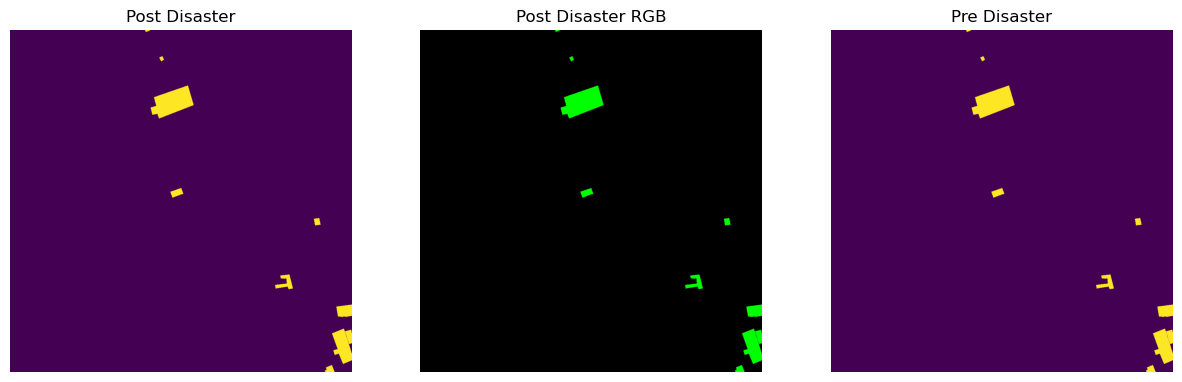

model inputs and outputs


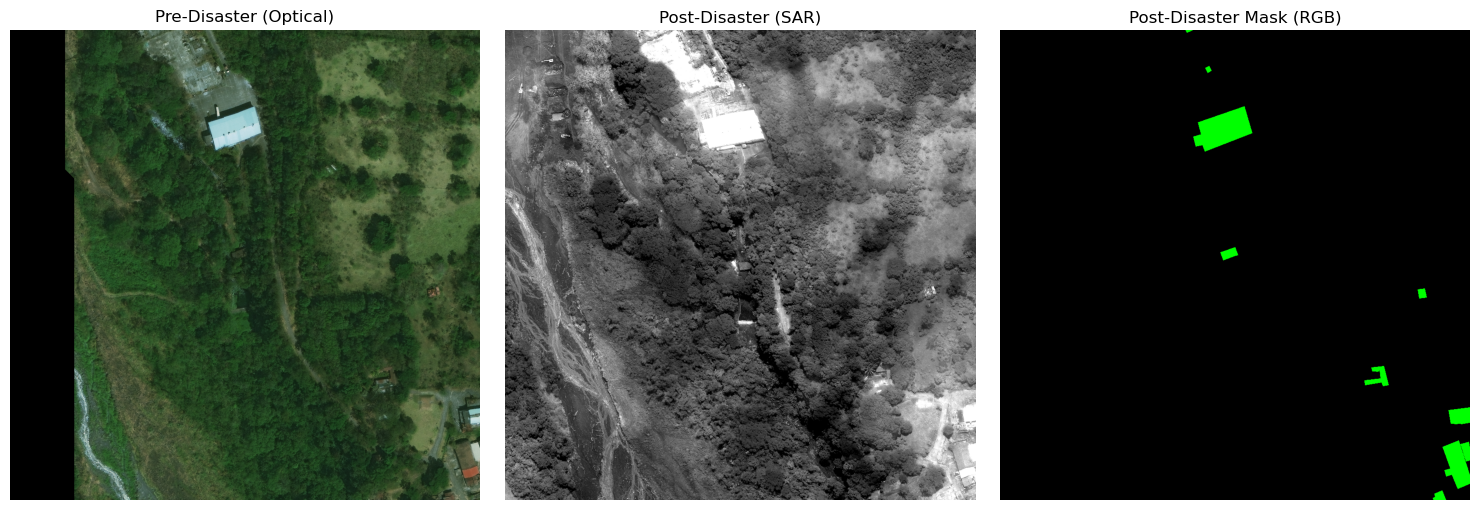

In [29]:
from PIL import Image
import matplotlib.pyplot as plt
import os

data_root = r"C:\Users\sweta\.cache\kagglehub\datasets\qianlanzz\xbd-dataset\versions\1\xbd"
file_path = os.path.join(data_root, "tier1", "masks")

files = [
    "guatemala-volcano_00000000_post_disaster.png",
    "guatemala-volcano_00000000_post_disaster_rgb.png",
    "guatemala-volcano_00000000_pre_disaster.png"
]

images = [Image.open(os.path.join(file_path, fname)) for fname in files]

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
titles = ["Post Disaster", "Post Disaster RGB", "Pre Disaster"] 

for ax, img, title in zip(axs, images, titles):
    ax.imshow(img)
    ax.set_title(title)
    ax.axis('off')

plt.show()

#the models inputs are (1) pre-diaster optical image + (2) post-disaster SAR image,, the output is a binary classification (black and white) of damaged vs undamaged
print("model inputs and outputs")
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import os

data_root = r"C:\Users\sweta\.cache\kagglehub\datasets\qianlanzz\xbd-dataset\versions\1\xbd"
images_path = os.path.join(data_root, "tier1", "images")
masks_path = os.path.join(data_root, "tier1", "masks")

pre_img_file = "guatemala-volcano_00000000_pre_disaster.png"
post_img_file = "guatemala-volcano_00000000_post_disaster.png"
mask_rgb_file = "guatemala-volcano_00000000_post_disaster_rgb.png"

def optical_to_sar_like(img):
    img = img.convert('L') 
    img = ImageOps.autocontrast(img, cutoff=2)
    return img

pre_img = Image.open(os.path.join(images_path, pre_img_file))
post_img = Image.open(os.path.join(images_path, post_img_file))
post_img_sar = optical_to_sar_like(post_img)
mask_rgb = Image.open(os.path.join(masks_path, mask_rgb_file)) #i will have to edit this to make it fit with the BRIGHT one I used while training (either binary or classification). maybe my next step is to create a function for both?

import numpy as np

def update_mask_binary(mask_rgb_img):
    """
    Converts the RGB post-disaster mask to a binary mask:
    - 0: No damage (black or limegreen)
    - 1: Damage (everything else)
    """
    mask_np = np.array(mask_rgb_img)
    
    # Define RGB colors
    black = [0, 0, 0]
    limegreen = [50, 205, 50]  # limegreen (No damage)

    binary_mask = np.ones((mask_np.shape[0], mask_np.shape[1]), dtype=np.uint8)

    # Create masks for "background" or "no damage"
    mask_is_black = np.all(mask_np == black, axis=-1)
    mask_is_lime = np.all(mask_np == limegreen, axis=-1)

    binary_mask[mask_is_black | mask_is_lime] = 0

    return binary_mask  # shape (H, W), values 0 or 1

def update_mask_multiclass(mask_rgb_img):
    """
    Converts RGB mask into multiclass labels based on color.
    Class labels:
        0 = No damage / Background
        1 = Minor
        2 = Major
        3 = Destroyed
        4 = Unclassified
    """
    mask_np = np.array(mask_rgb_img)
    h, w, _ = mask_np.shape
    label_mask = np.zeros((h, w), dtype=np.uint8)

    # Define color-to-label mappings
    color_to_label = {
        (0, 0, 0): 0,                  # black: background
        (0, 255, 255): 0,             # cyan: no damage
        (0,0,255): 1,                 # blue: minor
        (255, 255, 0): 2,           # yellow: major
        (255, 0, 0): 3,            # red: destroyed
        (211, 211, 211): 0            # lightgray: unclassified (will assume no damage)
    }

    for rgb, label in color_to_label.items():
        mask = np.all(mask_np == rgb, axis=-1)
        label_mask[mask] = label

    return label_mask  # shape (H, W), values 0–4


fig, axs = plt.subplots(1, 3, figsize=(15, 5))
titles = ["Pre-Disaster (Optical)", "Post-Disaster (SAR)", "Post-Disaster Mask (RGB)"]
images = [pre_img, post_img_sar, mask_rgb]

for ax, img, title in zip(axs, images, titles):
    # grayscale colormap for SAR image
    if title == "Post-Disaster (SAR)":
        ax.imshow(img, cmap='gray')
    else:
        ax.imshow(img)
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()

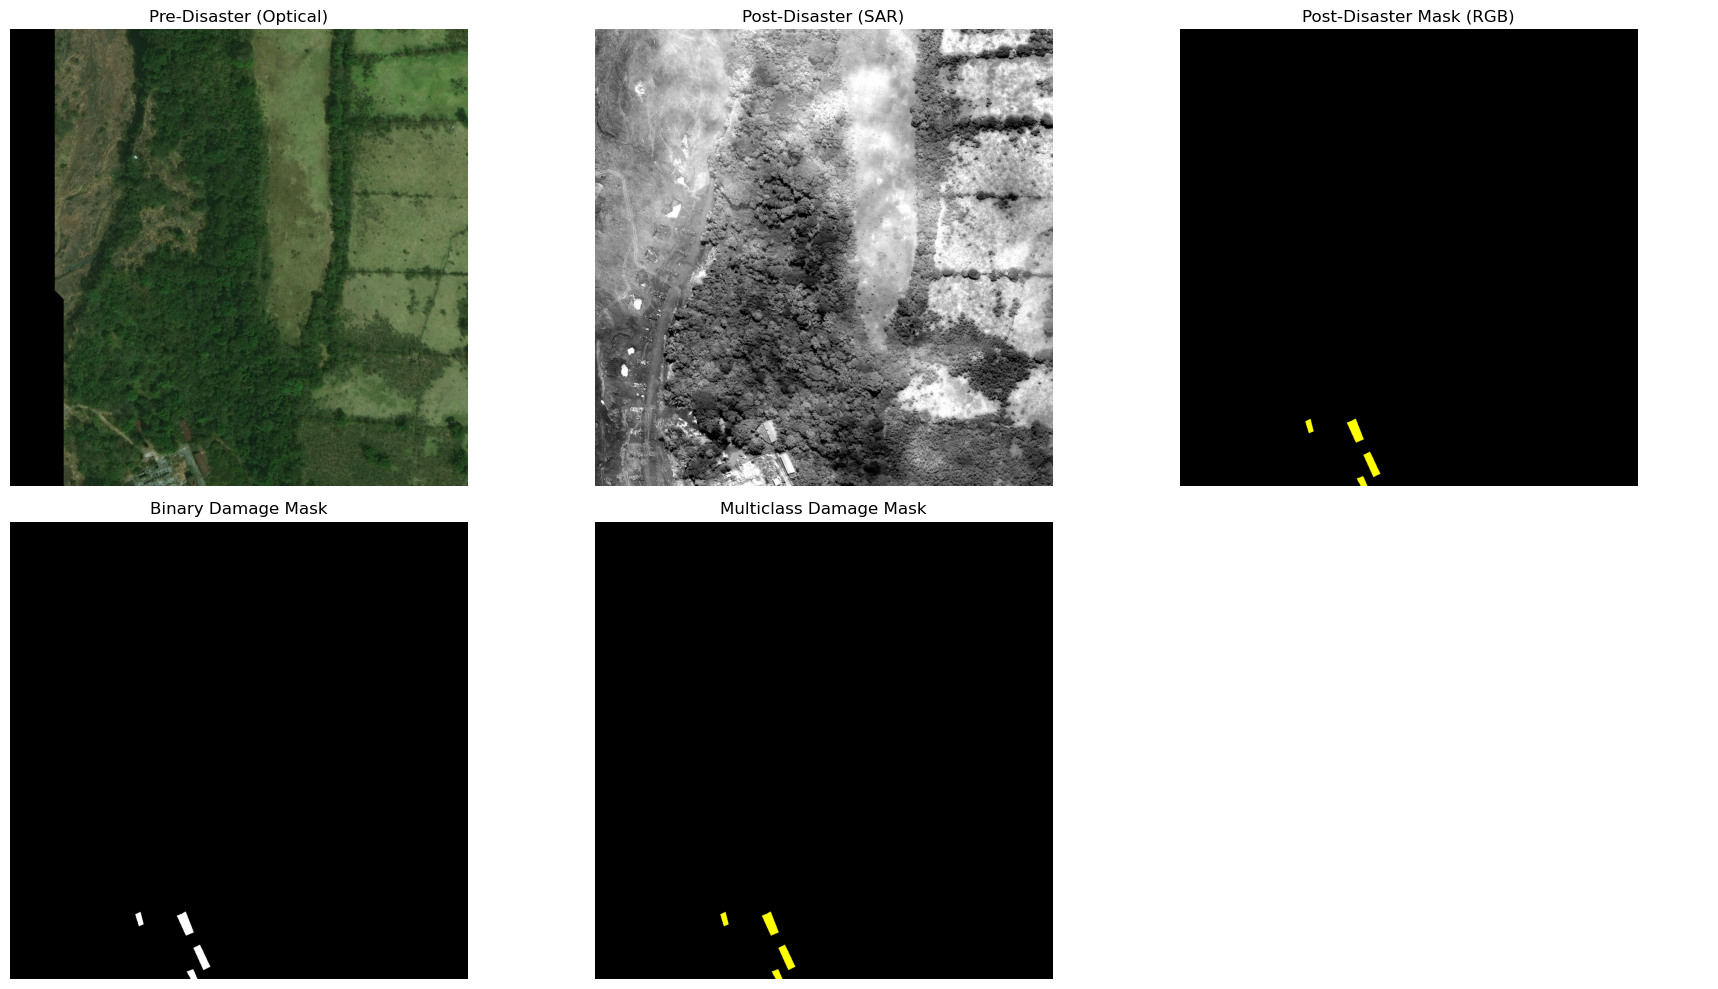

In [30]:
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import numpy as np
import os

data_root = r"C:\Users\sweta\.cache\kagglehub\datasets\qianlanzz\xbd-dataset\versions\1\xbd"
images_path = os.path.join(data_root, "tier1", "images")
masks_path = os.path.join(data_root, "tier1", "masks")

pre_img_file = "guatemala-volcano_00000001_pre_disaster.png"
post_img_file = "guatemala-volcano_00000001_post_disaster.png"
mask_rgb_file = "guatemala-volcano_00000001_post_disaster_rgb.png"

def optical_to_sar_like(img):
    img = img.convert('L') 
    img = ImageOps.autocontrast(img, cutoff=2)
    return img

pre_img = Image.open(os.path.join(images_path, pre_img_file))
post_img = Image.open(os.path.join(images_path, post_img_file))
post_img_sar = optical_to_sar_like(post_img)
mask_rgb = Image.open(os.path.join(masks_path, mask_rgb_file))

def update_mask_binary(mask_rgb_img):
    mask_np = np.array(mask_rgb_img)
    black = [0, 0, 0]
    limegreen = [50, 205, 50]  # no damage
    
    binary_mask = np.ones((mask_np.shape[0], mask_np.shape[1]), dtype=np.uint8)
    mask_is_black = np.all(mask_np == black, axis=-1)
    mask_is_lime = np.all(mask_np == cyan, axis=-1)
    binary_mask[mask_is_black | mask_is_lime] = 0
    return binary_mask

def update_mask_multiclass(mask_rgb_img): #something is wrong with this,, it works but not propoerly,, perhaps the label color_label things are wrong [MOST LIKELY];; there's yellow??
    mask_np = np.array(mask_rgb_img)
    h, w, _ = mask_np.shape
    label_mask = np.zeros((h, w), dtype=np.uint8)

    color_to_label = {
        (0, 0, 0): 0,                  # black: background
        (0, 255, 255): 0,             # cyan: no damage
        (0,0,255): 1,                 # blue: minor
        (255, 255, 0): 2,           # yellow: major
        (255, 0, 0): 3,            # red: destroyed
        (211, 211, 211): 0            # lightgray: unclassified (will assume no damage)
    }


    for rgb, label in color_to_label.items():
        mask = np.all(mask_np == rgb, axis=-1)
        label_mask[mask] = label

    return label_mask

# Generate masks
binary_mask = update_mask_binary(mask_rgb)
multiclass_mask = update_mask_multiclass(mask_rgb)

import matplotlib.colors as mcolors
damage_colors = ['black', 'blue', 'yellow', 'red']
cmap = mcolors.ListedColormap(damage_colors)
norm = mcolors.BoundaryNorm(boundaries=[-0.5,0.5,1.5,2.5,3.5], ncolors=len(damage_colors))

# Plot all images
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

titles_row1 = ["Pre-Disaster (Optical)", "Post-Disaster (SAR)", "Post-Disaster Mask (RGB)"]
images_row1 = [pre_img, post_img_sar, mask_rgb]

for ax, img, title in zip(axs[0], images_row1, titles_row1):
    if title == "Post-Disaster (SAR)":
        ax.imshow(img, cmap='gray')
    else:
        ax.imshow(img)
    ax.set_title(title)
    ax.axis('off')

# Plot binary and multiclass masks on second row
axs[1,0].imshow(binary_mask, cmap='gray')
axs[1,0].set_title("Binary Damage Mask")
axs[1,0].axis('off')

axs[1,1].imshow(multiclass_mask, cmap=cmap, norm=norm)
axs[1,1].set_title("Multiclass Damage Mask")
axs[1,1].axis('off')

# Leave last plot empty or show legend/colorbar
axs[1,2].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
#The next step is to start training the models to take in pre-disaster optical image, post-disaster SAR image. The output of the model will be the mutliclass damage mask. Creating the model will be done in 02. 